In [4]:
import matplotlib.pyplot as plt
import glob
import cv2
import pandas as pd
import numpy as np
import os
import warnings
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

%matplotlib inline
warnings.filterwarnings('ignore')

In [5]:
SIZE = 256

In [6]:
path = "C:/Users/PC/Documents/Eye_diseases_dataset/"
df_images = pd.read_csv(path + "/dataset.csv",
                        sep=";")

In [7]:
train_images = []
train_labels = [] 

for directory_path in glob.glob("C:/Users/PC/Documents/Eye_diseases_dataset/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

cataratas
glaucoma
normal
retinopatia


In [8]:
train_images.shape

(480, 256, 256, 3)

In [9]:
test_images = []
test_labels = [] 

for directory_path in glob.glob("C:/Users/PC/Documents/Eye_diseases_dataset/test/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [14]:
np.unique(train_labels)

array(['cataratas', 'glaucoma', 'normal', 'retinopatia'], dtype='<U11')

In [18]:
print(str(np.unique(train_labels)))

['cataratas' 'glaucoma' 'normal' 'retinopatia']


numpy.ndarray

In [9]:
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
print(np.unique(train_labels_encoded))

[0 1 2 3]


In [11]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [12]:
x_train, x_test = x_train / 255, x_test / 255

In [13]:
VGG_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (SIZE, SIZE, 3))

for layer in VGG_model.layers:
    layer.trainable = False
    
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [14]:
feature_extractor = VGG_model.predict(x_train)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_for_training = features

15/15 [==============================] - 39s 2s/step


In [15]:
X_for_training.shape

(480, 32768)

In [16]:
import xgboost as xgb
model = xgb.XGBClassifier(tree_method = 'gpu_hist', gpu_id = 0)
model.fit(X_for_training, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [17]:
prediction_train = model.predict(X_for_training)
# prediction_train = le.inverse_transform(prediction_train)

<Axes: >

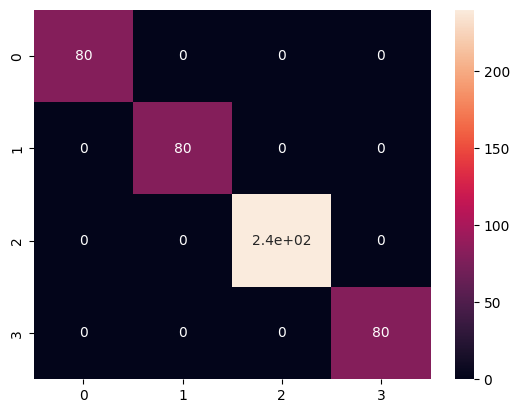

In [18]:
cm = confusion_matrix(y_train, prediction_train)
sns.heatmap(cm, annot = True)

In [19]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

4/4 [==============================] - 9s 2s/step


In [20]:
prediction = model.predict(X_test_features)
prediction = le.inverse_transform(prediction)

In [21]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.6583333333333333


<Axes: >

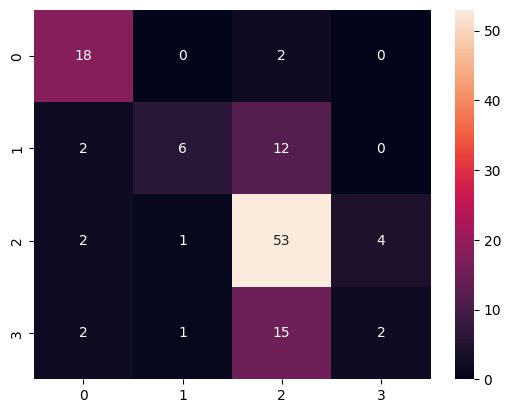

In [22]:
cm = confusion_matrix(test_labels, prediction)
sns.heatmap(cm, annot = True)

1/1 [==============================] - 0s 121ms/step
The prediction for this image is:  ['normal']
The actual label for this image is:  retinopatia


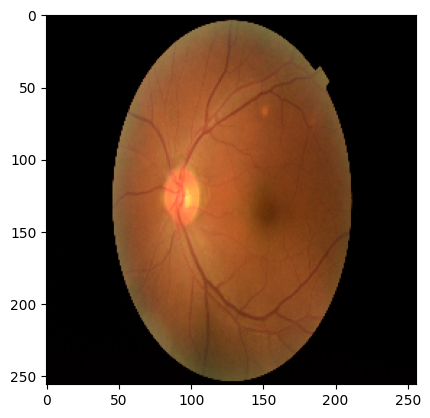

In [33]:
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis = 0) 
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0] 
prediction = le.inverse_transform([prediction])  
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])